In [ ]:
%pip install tensorflow

In [ ]:
!pip install rouge-score


In [ ]:
import torch
print(torch.cuda.is_available())  # For PyTorch

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))  # For TensorFlow


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Add

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import gdown

image_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
caption_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

os.makedirs("flickr8k", exist_ok=True)

image_zip_path = "flickr8k/Flickr8k_Dataset.zip"
gdown.download(image_url, image_zip_path, quiet=False)

caption_zip_path = "flickr8k/Flickr8k_text.zip"
gdown.download(caption_url, caption_zip_path, quiet=False)

with zipfile.ZipFile(image_zip_path, "r") as zip_ref:
    zip_ref.extractall("flickr8k/")

with zipfile.ZipFile(caption_zip_path, "r") as zip_ref:
    zip_ref.extractall("flickr8k/")

print("Dataset downloaded and extracted.")


Downloading...
From: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
To: /content/flickr8k/Flickr8k_Dataset.zip
100%|██████████| 1.12G/1.12G [00:07<00:00, 146MB/s]
Downloading...
From: https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
To: /content/flickr8k/Flickr8k_text.zip
100%|██████████| 2.34M/2.34M [00:00<00:00, 53.5MB/s]


Dataset downloaded and extracted.


In [ ]:
caption_file = "/content/flickr8k/Flickr8k.token.txt"
captions = open(caption_file, 'r').read().split("\n")

image_captions = {}
for line in captions:
    tokens = line.split("\t")
    if len(tokens) < 2:
        continue
    image_id, caption = tokens[0].split("#")[0], tokens[1].lower()
    if image_id not in image_captions:
        image_captions[image_id] = []
    image_captions[image_id].append("startseq " + caption.strip() + " endseq")

image_list = list(image_captions.keys())[:1000]
image_captions = {img: image_captions[img] for img in image_list}

print(f"Selected {len(image_captions)} images.")


Selected 1000 images.


In [ ]:
inception = InceptionV3(weights="imagenet")
model_new = Model(inception.input, inception.layers[-2].output)

def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return preprocess_input(img)

image_features = {}
image_folder = "/content/flickr8k/Flicker8k_Dataset"
for img_name in image_list:
    img_path = os.path.join(image_folder, img_name)
    img = preprocess_image(img_path)
    feature = model_new.predict(img)
    image_features[img_name] = feature.flatten()

print("Extracted features for 1500 images.")


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1

In [ ]:
all_captions = []
for key in image_captions.keys():
    all_captions.extend(image_captions[key])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

max_length = max(len(c.split()) for c in all_captions)
vocab_size = len(tokenizer.word_index) + 1

print(f"Vocabulary Size: {vocab_size}, Max Caption Length: {max_length}")


Vocabulary Size: 3224, Max Caption Length: 37


In [ ]:
image_input = Input(shape=(2048,))
img_embedding = Dense(256, activation="relu")(image_input)

caption_input = Input(shape=(max_length,))
caption_embedding = Embedding(vocab_size, 256, mask_zero=True)(caption_input)
lstm_output = LSTM(256)(caption_embedding)

merged = Add()([img_embedding, lstm_output])
dense_output = Dense(256, activation="relu")(merged)
output = Dense(vocab_size, activation="softmax")(dense_output)

captioning_model = Model(inputs=[image_input, caption_input], outputs=output)
captioning_model.compile(loss="categorical_crossentropy", optimizer="adam")

captioning_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 37)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 37, 256)        │        825,344 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 37)             │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ embedding[0][0],       │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3224)           │        828,568 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,769,560 (10.57 MB)

 Trainable params: 2,769,560 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_image, X_text, y = [], [], []

for img, captions in image_captions.items():
    img_feature = image_features[img]
    for caption in captions:
        sequence = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(sequence)):
            X_image.append(img_feature)
            X_text.append(sequence[:i])
            y.append(sequence[i])

X_image = np.array(X_image)
X_text = pad_sequences(X_text, maxlen=max_length, padding='post')
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print("Training data prepared.")


Training data prepared.


Epoch 1/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.8241
Epoch 2/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 3.5443
Epoch 3/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.1585
Epoch 4/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 2.8373
Epoch 5/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - loss: 2.5905
Epoch 6/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 2.3340
Epoch 7/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 2.1098
Epoch 8/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.8964
Epoch 9/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 1.6836
Epoch 10/10
1881/1881 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 1.5018


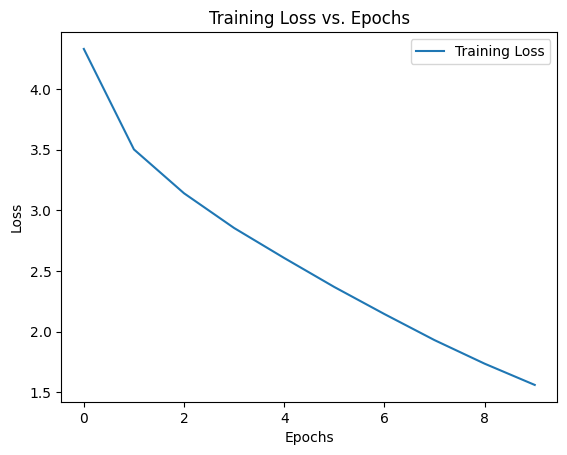

In [ ]:
history = captioning_model.fit([X_image, X_text], y, epochs=10, batch_size=32, verbose=1)

plt.plot(history.history['loss'], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training & validation loss and accuracy.
    """
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('accuracy', []), label='Training Accuracy', color='blue')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    plt.show()


In [ ]:
def generate_caption(model, image, tokenizer, max_length):
    caption = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([image, sequence])
        word = tokenizer.index_word[np.argmax(y_pred)]
        caption += " " + word
        if word == "endseq":
            break
    return caption.replace("startseq", "").replace("endseq", "").strip()


In [ ]:
# Test on sample images
for i, img_name in enumerate(image_list[:1]):
    test_img = preprocess_image(os.path.join(image_folder, img_name))
    test_img_feature = model_new.predict(test_img).reshape(1, 2048)  # Correct shape
    print(f"Generated Caption {i+1}: {generate_caption(captioning_model, test_img_feature, tokenizer, max_length)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Generated Caption 1: a man in a blue shirt is holding a cigarette in his mouth


Validation


In [ ]:
BASE_DIR = "/content/flickr8k"
CAP_TEXT_PATH = os.path.join(BASE_DIR, "Flickr8k.token.txt")
TRAIN_TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.trainImages.txt")
TEST_TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.testImages.txt")
VAL_TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.devImages.txt")
TXT_PATH = os.path.join(BASE_DIR, "Flickr_8k.trainImages.txt")
print("Paths updated for Google Colab!")

Paths updated for Google Colab!


In [ ]:
def clean_cap(caption: str) -> str:
    cap = ''.join([ch for ch in caption if ch not in string.punctuation])
    cap = cap.split()
    cap = [word.casefold() for word in cap]
    cap = [word for word in cap if len(word) > 1]
    cap = [word for word in cap if word.isalpha()]
    lemmatizer = nltk.WordNetLemmatizer()
    cap = [lemmatizer.lemmatize(word) for word in cap]
    return ' '.join(cap)

In [ ]:
def load_cap(caption_txt_path: str) -> dict:
    with open(caption_txt_path, 'r', encoding='utf-8') as caption_txt:
        captions_list = caption_txt.readlines()
    mapping = dict()
    for line in captions_list:
        caption = line.split('\t')
        image_name = caption[0][:-2].split('.')[0]
        image_caption = clean_cap(caption[-1][:-1])
        image_caption = 'startofseq ' + image_caption + ' endofseq'
        if image_name in mapping:
            mapping[image_name].append(image_caption)
        else:
            mapping[image_name] = [image_caption]
    return mapping

In [ ]:
def save_captions(mapping: dict, filename: str) -> bool:
    lines = [key + ' ' + cap for key, cap_list in mapping.items() for cap in cap_list]
    with open(filename, 'w') as file:
        file.write('\n'.join(lines))
    return True

In [ ]:
def load_doc(filename: str) -> str:
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

In [ ]:
def load_set(text_file_path: str) -> set:
    doc = load_doc(text_file_path)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [ ]:
def load_clean_cap(caption_txt_path: str, dataset: set) -> dict:
    doc = load_doc(caption_txt_path)
    clean_captions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_name, image_cap = tokens[0], " ".join(tokens[1:])
        if image_name in dataset:
            if image_name not in clean_captions:
                clean_captions[image_name] = list()
            clean_captions[image_name].append(image_cap)
    return clean_captions

In [ ]:
def max_len(clean_captions: dict) -> int:
    clean_captions_list = [caption.split() for captions in clean_captions.values()
                           for caption in captions]
    return max(len(caption) for caption in clean_captions_list)

In [ ]:
def create_tokenizer(captions_dict: dict, top_k: int = 2000) -> Tokenizer:
    clean_captions_list = [caption for captions in captions_dict.values()
                           for caption in captions]
    tokenizer = Tokenizer(num_words=top_k, oov_token="<unk>")
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    tokenizer.fit_on_texts(clean_captions_list)
    return tokenizer

In [ ]:
def path_cap_list(img_names_set: set, tokenizer: Tokenizer, captions_dict) -> (list, list):
    tokenized_caps_dict = tokenize_cap(tokenizer, captions_dict)
    image_name_list = sorted(img_names_set)
    capt_list = [cap for name in image_name_list for cap in tokenized_caps_dict[name]]
    img_path_list = [img_name_2_path(name) for name in image_name_list for i in range(len(tokenized_caps_dict[name]))]
    return img_path_list, capt_list

In [ ]:
def load_npy(image_path: str, cap: str) -> (str, str):
    """
    :returns image tensor vector with the image path
    :param image_path:
    :param cap:
    """
    img_tensor = np.load(image_path.decode('utf-8') + '.npy')
    return img_tensor, cap

In [ ]:
def create_dataset(img_path_list: str, cap_list: str) -> object:
    """
    :param img_path_list: The ordered list of img paths with duplication acc to number of captions
    :param cap_list: the padded caption list with the curr order
    :return: dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices((img_path_list, cap_list))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
CAP_TEXT_PATH

'/content/flickr8k/Flickr8k.token.txt'

In [ ]:
CLEAN_CAP_TEXT_PATH = "/content/flickr8k/Flickr8k_clean_cap.txt"

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import string

In [ ]:
cap_dict = load_cap(CAP_TEXT_PATH)

In [ ]:
save_captions(cap_dict,CLEAN_CAP_TEXT_PATH)

True

In [ ]:
VAL_TXT_PATH = "/content//Flickr_8k.devImages.txt"

In [ ]:
val_img_names = sorted(load_set(TEST_TXT_PATH))

In [ ]:
val_img_cap = load_clean_cap(CLEAN_CAP_TEXT_PATH, val_img_names)

In [ ]:
len(val_img_cap)

1000

In [ ]:
IMG_FILE_PATH = "/content/flickr8k/Flicker8k_Dataset/"

In [ ]:
def img_name_2_path(image_name: str, img_file_path: str = IMG_FILE_PATH, ext: str = r".jpg") -> str:
    image_path = img_file_path + str(image_name) + ext
    return image_path

In [ ]:
image_name = val_img_names[np.random.randint(0, len(val_img_names))]
img_path = img_name_2_path(image_name)
real_captions = val_img_cap[image_name]

In [ ]:
image_name

'3647750811_395fbd397e'

In [ ]:
img_path

'/content/flickr8k/Flicker8k_Dataset/3647750811_395fbd397e.jpg'

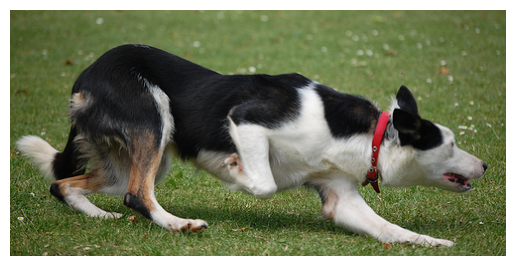

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(img_path):
    """Loads and displays an image using Matplotlib."""
    img = mpimg.imread(img_path)  # Read image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.show()

# Example usage
show_image(img_path)

In [ ]:
# Function to tokenize captions
def tokenize_cap(tokenizer, captions_dict):
    """
    Tokenize all captions in the dictionary

    Args:
        tokenizer: The Keras tokenizer object
        captions_dict: Dictionary of image names and their captions

    Returns:
        Dictionary with tokenized captions
    """
    tokenized_caps = {}
    for img_name, caps in captions_dict.items():
        tokenized_caps[img_name] = []
        for cap in caps:
            sequence = tokenizer.texts_to_sequences([cap])[0]
            tokenized_caps[img_name].append(sequence)
    return tokenized_caps

# Define the buffer size and batch size constants
BUFFER_SIZE = 1000
BATCH_SIZE = 32

# Function to generate caption for a specific image
def generate_caption_for_image(model, image_path, tokenizer, max_length):
    """
    Generate a caption for a given image

    Args:
        model: The trained captioning model
        image_path: Path to the image file
        tokenizer: The tokenizer used for text processing
        max_length: Maximum length of the caption

    Returns:
        Generated caption as a string
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Extract features using InceptionV3
    inception = InceptionV3(weights="imagenet")
    model_new = Model(inception.input, inception.layers[-2].output)
    feature = model_new.predict(img)
    feature = feature.reshape(1, 2048)  # Ensure correct shape

    # Generate caption
    caption = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([caption])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        y_pred = model.predict([feature, sequence])
        word_idx = np.argmax(y_pred)
        word = tokenizer.index_word.get(word_idx, "")
        caption += " " + word
        if word == "endseq":
            break

    # Clean up the caption by removing start and end tokens
    caption = caption.replace("startseq", "").replace("endseq", "").strip()
    return caption

In [ ]:
caption = generate_caption_for_image( captioning_model,img_path, tokenizer, max_length)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
caption

'a brown dog is running after a yellow and red ball'

In [ ]:
print(caption)
print('Real Captions:')
for i, cap in enumerate(real_captions):
    print(f"{i+1}) {cap[10:-8]}")

a brown dog is running after a yellow and red ball
Real Captions:
1)  black and white dog is wearing red collar whilst walking on the grass 
2)  dog is running awkwardly 
3)  multicolor dog in red collar crouching on the grass 
4)  black brown and white dog crouch on three leg in the grass 
5)  the dog with the red collar is white black and brown 


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score

nltk.download('wordnet')
nltk.download('omw-1.4')

def calculate_metrics(pred_caption, real_captions):

    pred_tokens = pred_caption.split()
    real_tokens = [caption.split() for caption in real_captions]
    smoothie = SmoothingFunction().method1
    bleu_1 = sentence_bleu(real_tokens, pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)  # BLEU-1
    bleu_2 = sentence_bleu(real_tokens, pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)  # BLEU-2
    bleu_3 = sentence_bleu(real_tokens, pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)  # BLEU-3
    bleu_4 = sentence_bleu(real_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)  # BLEU-4

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(pred_caption, cap) for cap in real_captions]
    avg_rouge = {
        "rouge1": sum([s['rouge1'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        "rouge2": sum([s['rouge2'].fmeasure for s in rouge_scores]) / len(rouge_scores),
        "rougeL": sum([s['rougeL'].fmeasure for s in rouge_scores]) / len(rouge_scores),
    }

    # METEOR Score Calculation (Fixed)
    meteor_scores = [meteor_score([cap.split()], pred_tokens) for cap in real_captions]  # Pass tokenized captions
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    return {
        "BLEU-1": bleu_1,
        "BLEU-2": bleu_2,
        "BLEU-3": bleu_3,
        "BLEU-4": bleu_4,
        "ROUGE-1": avg_rouge["rouge1"],
        "ROUGE-2": avg_rouge["rouge2"],
        "ROUGE-L": avg_rouge["rougeL"],
        "METEOR": avg_meteor
    }

predicted_caption = caption
metrics = calculate_metrics(predicted_caption, real_captions)

print("\nEvaluation Scores:")
for metric, score in metrics.items():
    print(f"{metric}: {score:.4f}")



Evaluation Scores:
BLEU-1: 0.5455
BLEU-2: 0.3303
BLEU-3: 0.2331
BLEU-4: 0.1109
ROUGE-1: 0.2998
ROUGE-2: 0.0700
ROUGE-L: 0.2351
METEOR: 0.2130


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
